# Gaussian Process Regression for WiFi Fingerprinting-based Localization

In this assignment, you will work with Gaussian process for regression. Recall in Assignment 1, we use a given path loss model and trilateration to determine locations using WiFi radio signal strenght (RSS) from different access points (AP). Training the path loss model itself can be done using polynomial regression. Indoor environments are generally quite complex and cannot be characterized using a single path loss model accurately. An alternative approach is to treat RSS vectors at each location as a *fingerprint*. If these fingerprints are unique, we can use them to determine locations.   

As an example, in the following figure, there are four APs. We use colors to represent the amplitude of RSS values (hot colors indicate higher values). As one moves away from an AP, the RSS decreases. However, the contour curves of equal RSS readings from one AP are often not circular (and thus the path loss model fails). 

![WiFi Fingerprint](RSS.jpg)

For simplicity, we only consider **2D localization**. The most naive approach is to build a lookup table of fingerprints and locations from training data. During testing, given the RSS measurements, one can search for the  location that gives the best match (by the nearest neighbor search). However, such a solution requires dense measurements across the target space since we do not know what the measurements are at locations not in the training set. Additionally, the naive lookup approach fails to account of uncertainty in RSS measurements that is prevalent in indoor environments. 

For an AP $i$, we can model the *mean* RSS value (in dBm) at location $(x_1, x_2)$ from AP $i$ as a function $f_i: R^2 \rightarrow R$. In the training phase, we conduct site survey and measure RSS values at a number of known locations. The training data $\{X, Y\}$ thus consists of $\{(x_1^j, x_2^j), (RSS_1^j, RSS_2^j, \ldots, RSS_m^j), j=1, 2, \ldots, N\}$, where $RSS_i^j$ is the RSS at $j$th location from AP $i$. Note that the number of visible APs tends to differ from one location to another. 

We assume $f_i$'s are drawn from $GP(m(x), k(x,x'))$, where $m(x)$ is the mean process and $k(x,x')$ is the kernel. With GP regression, we obtain the predictive model for RSS values from AP $i$ at an unknown location(s) $X_*$ by,
$$
f_i(X_*)| X, y, X_* \sim N(\bar{f_i}^*, cov(f_i^*)), 
$$
where $\bar{f_i}^* = K(X_*, X)[K(X,X) + \sigma_n^2I]^{-1}y_i$ and $cov(f_i^*) = K(X_*, X_*) - K(X_*, X)[K(X,X)+\sigma_n^2 I]^{-1}K(X,X_*)$

To determine the location a device given its RSS measurements $[RSS_{i_1}, RSS_{i_2}, \ldots, RSS_{i_l}]$, one uses the maximum a posteriori (MAP) estimation. Formally, 
$$
\arg\max_{X_*} \sum_{c = 1}^{l} \log f_{i_c}(X_*)| X, y, X_*
$$

One way to solve this optimization problem is to divide the search space into regular grids and find the grid point that maximizes the objective function. 

<br>
<font color="blue">
[Reference] 
Ferris, B, Hahnel, D & Fox, D 2007, Gaussian processes for signal strength-based location estimation. in Robotics: Science and Systems. vol. 2, MIT Press Journals, pp. 303-310, 2nd International Conference on Robotics Science and Systems, RSS 2006, Philadelphia, United States, 16-19 August.</font>

In [1]:
import ianus
import numpy as np
import matplotlib.pyplot as plt
import GPy 
import math 
from sklearn.model_selection import train_test_split
import scipy
from sklearn.model_selection import KFold

GPy package can be found at https://sheffieldml.github.io/GPy/ <br>
**Before you start the assignment, please go through the lecture slides and the GP demo discussed in class**

## 1. Read WiFi and Location Data
WiFi, AP and location data are similar to Assignment 1 with one minor difference. In AP.csv, only the mac address of APs are given. There are no locations of the APs. 

In [2]:
datapath = './dataset/'

X_raw, apinfo = ianus.read_wifi_ap_data(datapath+'wifi.pbf', datapath+'AP.csv')
Y = ianus.read_location_data(datapath + 'location.pbf')

mac_address = list(apinfo.keys())
num_AP = len(mac_address)
num_loc = Y.shape[1]

assert (num_loc == len(X_raw))

# Search space
min_X, min_Y, max_X, max_Y = [np.amin(Y[0]), np.amin(Y[1]), np.amax(Y[0]), np.max(Y[1])]

# Mesh for localization. Find a location among NxN grids points that maximizes a posteriori distribution
N = 50
mesh = np.meshgrid(np.linspace(min_X, max_X, N), np.linspace(min_Y, max_Y, N))
grid = np.array([mesh[0].reshape(N*N,1), mesh[1].reshape(N*N,1)]).squeeze().T

## 2. Gaussian Process Regression
Step 1. Parition the data into training and testing sets randomly (e.g., 90% of the locations and their RSS readings are in the training set and the remaining 10% in the testing set). <br>
Step 2. Train a GP for **each** feature (AP) using RBF kernel (maximally, there are num_AP GP's). <br>
Step 3. Optimize the hyper-parameters via optimization *model.optimize*

**Note: the training and testing set division is among locations NOT measurements from the same locations**

In [36]:
# Compue X_mean
X_mean = np.zeros((num_AP, num_loc))
for i in range(num_loc):
    num_scans = X_raw[i].shape[1]
    X_mean[:,i] = np.nanmean(X_raw[i][:,0:num_scans],axis=1)
X_mean = X_mean.T # The shape of X_mean is num_loc * num_AP

Y_new = Y.T[:,0:2]

X_train, X_test, Y_train, Y_test = train_test_split(Y_new, X_mean, test_size = 0.1)

GP = []
GP_index = []
for i in range(num_AP):
    X = X_train[~np.isnan(Y_train[:,i])]
    Y_AP = Y_train[:,i]
    Y_AP = Y_AP[~np.isnan(Y_AP)]
    Y_AP = np.reshape(Y_AP,(Y_AP.shape[0],1))

    if(X.shape[0] > 10):
        kernel = GPy.kern.RBF(input_dim=2,lengthscale =10)
        m = GPy.models.GPRegression(X,Y_AP,kernel)
        m.optimize(messages=False,max_f_eval = 1000)
        GP.append(m)
        GP_index.append(i)
    

 C:\Users\wenqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:Mean of empty slice
 C:\Users\wenqi\Anaconda3\lib\site-packages\GPy\kern\src\rbf.py:43: RuntimeWarning:overflow encountered in square
 C:\Users\wenqi\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 C:\Users\wenqi\Anaconda3\lib\site-packages\GPy\kern\src\rbf.py:46: RuntimeWarning:invalid value encountered in multiply


Step 4. For each test location, solve the MAP estimation from the RSS readings in the test set. 

- First, use model.predict(grid) to get the mean and variance of the RSS of *each* AP at all mesh grid locations 
- Second, for each test data in the test set, 1) evaluate the log of the probability density function at each mesh grid point for each AP and compute the sum 2) find the grid point with the maximum *sum* logpdf and save the location as inferred location to Y_hat.
    - Note: *nan* entries should not be included in the evaluation

**Hint: you can use scipy.stats.normal.logpdf (scipy.stats.multivariate_normal.logpdf) to compute the log pdf of (multivariate) Gaussian distribution**

In [37]:
GP_num = len(GP)

mean = np.zeros([grid.shape[0],GP_num])
var = np.zeros([grid.shape[0],GP_num])
for i in range(GP_num):
    result = GP[i].predict(grid)
    mean[:,i] = result[0].reshape((grid.shape[0],))
    var[:,i] = result[1].reshape((grid.shape[0],))

num_test = X_test.shape[0]
Y_hat = np.zeros([num_test,2])
for num in range(num_test):
    sum = np.zeros(grid.shape[0])
    for p in range(grid.shape[0]):
        for k in range(GP_num):
            RSS = Y_test[num,GP_index[k]]
            if (~np.isnan(RSS)):
                sum[p] += scipy.stats.multivariate_normal.logpdf(RSS,mean[p,k],math.sqrt(var[p,k]))
    max_index = np.argmax(sum)
    Y_hat[num] = grid[max_index]    

    5. Compute the prediction errors and visualize the results

Mean localization error = 1.390601


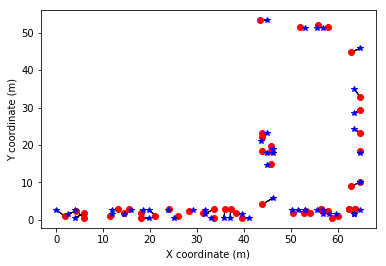

In [38]:
# Assume the ground truth locations and inferred locatios are stored in Y_testing and Y_hat
Y_testing = X_test.T
Y_hat = Y_hat.T

errors = np.linalg.norm(Y_testing - Y_hat, axis=0)
print("Mean localization error = %f"%np.mean(errors))

plt.plot(Y_testing[0,:], Y_testing[1,:], 'ro')
plt.plot(Y_hat[0,:], Y_hat[1,:], 'b*')
plt.xlabel('X coordinate (m)')
plt.ylabel('Y coordinate (m)')
for i in range(Y_testing.shape[1]):
    plt.arrow(Y_testing[0,i], Y_testing[1,i], Y_hat[0,i]-Y_testing[0,i], Y_hat[1,i]-Y_testing[1,i])

plt.show()

## 3. 10-fold validation and compute the average error

In [3]:
X_mean = np.zeros((num_AP, num_loc))
for i in range(num_loc):
    num_scans = X_raw[i].shape[1]
    X_mean[:,i] = np.nanmean(X_raw[i][:,0:num_scans],axis=1)
X_mean = X_mean.T
Y_new = Y.T[:,0:2]
error_sum = 0
X = Y_new
y = X_mean

kf = KFold(n_splits=10)
kf.get_n_splits(X) 
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

    GP = []
    GP_index = []
    for i in range(num_AP):
        X_AP = X_train[~np.isnan(Y_train[:,i])]
        Y_AP = Y_train[:,i]
        Y_AP = Y_AP[~np.isnan(Y_AP)]
        Y_AP = np.reshape(Y_AP,(Y_AP.shape[0],1))

        if(X_AP.shape[0] > 10):
            kernel = GPy.kern.RBF(input_dim=2,lengthscale =10)
            m = GPy.models.GPRegression(X_AP,Y_AP,kernel)
            m.optimize(messages=False,max_f_eval = 1000)
            GP.append(m)
            GP_index.append(i)

    GP_num = len(GP)
    mean = np.zeros([grid.shape[0],GP_num])
    var = np.zeros([grid.shape[0],GP_num])
    for i in range(GP_num):
        result = GP[i].predict(grid)
        mean[:,i] = result[0].reshape((grid.shape[0],))
        var[:,i] = result[1].reshape((grid.shape[0],))

    num_test = X_test.shape[0]
    Y_hat = np.zeros([num_test,2])
    for num in range(num_test):
        sum = np.zeros(grid.shape[0])
        for p in range(grid.shape[0]):
            for k in range(GP_num):
                RSS = Y_test[num,GP_index[k]]
                if (~np.isnan(RSS)):
                    sum[p] += scipy.stats.multivariate_normal.logpdf(RSS,mean[p,k],math.sqrt(var[p,k]))
        max_index = np.argmax(sum)
        Y_hat[num] = grid[max_index]
        

    Y_testing = X_test.T
    Y_hat = Y_hat.T
    errors = np.linalg.norm(Y_testing - Y_hat, axis=0)
    print("Mean localization error = %f"%np.mean(errors))
    error_sum += np.mean(errors)
cross_validation_error = error_sum/10
print("error by 10-folds validation = %f"%cross_validation_error)

 C:\Users\wenqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:Mean of empty slice
 C:\Users\wenqi\Anaconda3\lib\site-packages\GPy\kern\src\rbf.py:43: RuntimeWarning:overflow encountered in square


Mean localization error = 1.939795
Mean localization error = 2.023509


 C:\Users\wenqi\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 C:\Users\wenqi\Anaconda3\lib\site-packages\GPy\kern\src\rbf.py:46: RuntimeWarning:invalid value encountered in multiply


Mean localization error = 1.491400
Mean localization error = 2.075831
Mean localization error = 2.511497
Mean localization error = 2.050776
Mean localization error = 1.870015
Mean localization error = 1.984424
Mean localization error = 1.910044
Mean localization error = 1.430314
error by 10-folds validation = 1.928761


## Report and Submission
1. In hyperparameter optimization, you can include constraints to limit the search space for the hyperparameters. Evaluate the impact of constraints on the value of the objective function reported by GP regression and on localization errors. 
2. Vary the mesh size, repeat the above experiments. [Note the computation complexity increases linearly with the # of grid points]. 
3. Partition the data into 10 equal partitions. Perform 10-fold cross validation and compute the average error.
4. (*Optional*) In inferring a location from the GP, we estimate the posterior probablity by evaluating the GP models of *all* APs. The contributions of the APs are weighted by the variance of their respective Gaussian distributions. It is expected that for some faraway APs, their variances are very large or in other words, the uncertainty of their predictions are high. To mitigate this, one can apply a threshold to  "filter" APs and only consider GP models of APs with variance lower than the threshold at the guessed location. Note that in this case, the log posterior probablity should be normalized by the number of APs considered. Evaluate whether this strategy can improve the localization accuracy with properly tuned threshold. 
5. Include your ipynb code and your report in a directory under the gitlab project folder you previously shared with the instructor.